In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import glob
import time
import warnings
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
%matplotlib notebook

if '../../../bayes-drt' not in sys.path:
    sys.path.append('../../../bayes-drt')
import drt
from stan_models import save_pickle,load_pickle
import eis_utils as gt

%load_ext autoreload
%autoreload 2

In [2]:
datadir = '../../../data'
outdir = 'results'

In [50]:
def ricv_score(drr,dri,freq,Zc,**kw):
    # calculate re-im CV score
    drr.ridge_fit(freq,Zc,part='real',**kw)
    dri.ridge_fit(freq,Zc,part='imag',**kw)

    Zi_pred = np.imag(drr.predict_Z(freq))
    Zr_pred = np.real(dri.predict_Z(freq))

    Zr_err = np.sum((Zc.real - Zr_pred)**2)
    Zi_err = np.sum((Zc.imag - Zi_pred)**2)

    return Zr_err, Zi_err

def plot_drt(tau,gamma,ax,label='',**kw):
    ax.plot(tau,gamma,label=label,**kw)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ / s')
    ax.set_ylabel(r'$\gamma \, (\tau) \ / \ \Omega$')
    
def plot_true_drt(circ,ax,trunc_tau_plot,Zdf,**kw):
    """plot true DRT. Must come after all other plotting functions and axis adjustments to ensure that 
    hlines and vlines are positioned corrrectly"""
    tmax = 1/(2*np.pi*Zdf['Freq'].min())
    tmin = 1/(2*np.pi*Zdf['Freq'].max())
    if circ=='RC':
        ax.axvline(1e-2,lw=1,ymin=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
        ax.axhline(0,zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0],**kw)
    elif circ=='2RC':
        ax.axvline(1e-2,lw=1,ymin=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
        ax.axvline(1e-3,lw=1,ymin=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
        ax.axhline(0,zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0],**kw)
    else:
        g_file = os.path.join(datadir,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        if trunc_tau_plot:
            g_true = g_true[(g_true['tau']>= tmin) & 
                            (g_true['tau']<= tmax)
                           ]
        ax.plot(g_true['tau'],g_true['gamma'],label='True',zorder=-10,**kw)
        
        if circ=='trunc':
            # add RL element and measurement boundaries
            ax.axvline(1e-6,lw=1,ymax=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
            ax.axvline(tmax,ls=':',c='k',lw=1)
            ax.axvline(tmin,ls=':',c='k',lw=1)
        elif circ=='RC-ZARC':
            # add RC element
            ymin = np.interp(np.exp(-2),g_true['tau'],g_true['gamma'])
            print(ymin)
            ax.axvline(np.exp(-2),ymin=ax.transLimits.transform((1,ymin))[1],zorder=-10,**kw)
            
#     ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ / s')
    ax.set_ylabel(r'$\gamma \, (\tau) \ / \ \Omega$')

def plot_drt_result(dr,Zdf,circ,trunc_tau_plot=True,axes=None,label='Fit'):
    if axes is None:
        fig,axes = plt.subplots(1,3,figsize=(10,3))
        ax1,ax2,ax3 = axes.ravel()
    else:
        ax1,ax2,ax3 = np.atleast_1d(axes).ravel()
        fig = ax1.get_figure()
        
    freq = Zdf['Freq'].values
        
    gt.plot_bode(Zdf,axes=[ax1,ax2],s=20,alpha=0.5,label='Data',cols=['Zreal','Zimag'],unit_scale='')
    Zpred = dr.predict_Z(freq)
    df_pred = gt.construct_eis_df(freq,Zpred)
    gt.plot_bode(df_pred,axes=[ax1,ax2],plot_func='plot',c='k',label=label,cols=['Zreal','Zimag'],unit_scale='')
    
    dist_name = list(dr.distributions.keys())[0]
    tau = 1/(2*np.pi*dr.distributions[dist_name]['tau'])
    tau_plot = np.logspace(np.min(np.log10(tau)),np.max(np.log10(tau)),200)
    plot_drt(tau_plot,dr.predict_distribution('DRT',tau_plot),ax3,label,c='k')
    plot_true_drt(circ,ax3,trunc_tau_plot,Zdf,ls='--')
    
    ax3.legend()
    fig.tight_layout()

In [51]:
def run_cv_fit(dr,file,basis_freq=None,epsilon=None,nonneg=True,penalty='discrete',**kw):
    circ = os.path.split(file)[1].split('_')[1]
    Zndf = pd.read_csv(file)
    freq = Zndf['Freq'].values
    Zc = (Zndf['Zreal'] + 1j*Zndf['Zimag']).values
    
    fit_kw = dict(reg_ord=2,dZ=False,scale_Z=False,nonneg=nonneg,
                  penalty=penalty,max_iter=50)
    fit_kw.update(kw)
    lambdas = np.logspace(-15,0,61)

    dr.epsilon = epsilon
    dr.ridge_fit(freq,Zc,lambda_0='cv',cv_lambdas=lambdas,hyper_lambda=False,**fit_kw)

    fig,axes = plt.subplots(2,2,figsize=(8,6))

    # plot Re-Im CV score as function of lambda_0
    axes[0,0].plot(dr.cv_result['lambda'],dr.cv_result['recv'],label='Real')
    axes[0,0].plot(dr.cv_result['lambda'],dr.cv_result['imcv'],label='Imag')
    axes[0,0].plot(dr.cv_result['lambda'],dr.cv_result['totcv'],label='Total')
    axes[0,0].legend()
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')

    # get best lambda_0
    min_lam = dr.cv_result['lambda'].values[np.argmin(dr.cv_result['totcv'])]
    if min_lam==np.min(lambdas) or min_lam==np.max(lambdas):
        warnings.warn('min_lam value {} for file {} is at lambda boundary!'.format(min_lam,os.path.split(file)[1]))
    axes[0,0].axvline(min_lam,c='k',ls=':')
    dr.ridge_fit(freq,Zc,lambda_0=min_lam,hyper_lambda=False,**fit_kw)
    plot_drt_result(dr,Zndf,circ,axes=[axes[0,1],axes[1,0],axes[1,1]],label='Ridge',trunc_tau_plot=False)

    # plot hyper DRTs with best lambda_0
    f_betas = [1e-3,1e-2,1e-1,1,1e1,1e2]
    for f_beta in [1e-2,1e-1,1]:#,1e-1,1]:#f_betas:
        dr.ridge_fit(freq,Zc,part='both',lambda_0=min_lam,hl_fbeta=f_beta,**fit_kw)
        dist_name = list(dr.distributions.keys())[0]
        tau = 1/(2*np.pi*dr.distributions[dist_name]['tau'])
        tau_plot = np.logspace(np.min(np.log10(tau)),np.max(np.log10(tau)),200)
        plot_drt(tau_plot,dr.predict_distribution(dist_name,tau_plot),ax=axes[1,1],label=f_beta)
        df_pred = gt.construct_eis_df(freq,dr.predict_Z(freq))
        gt.plot_bode(df_pred,axes=[axes[0,1],axes[1,0]],plot_func='plot',label=f_beta,cols=['Zreal','Zimag'])
        
    axes[1,1].legend()

## Epsilon values

ZARC: 2

2ZARC: 4.34 best; 3 ok

RC: 5

2RC: 5

Gerischer: 6

ZARC-RL: 3 (not too sensitive)

RC_ZARC: 4

trunc: 3-5



<IPython.core.display.Javascript object>


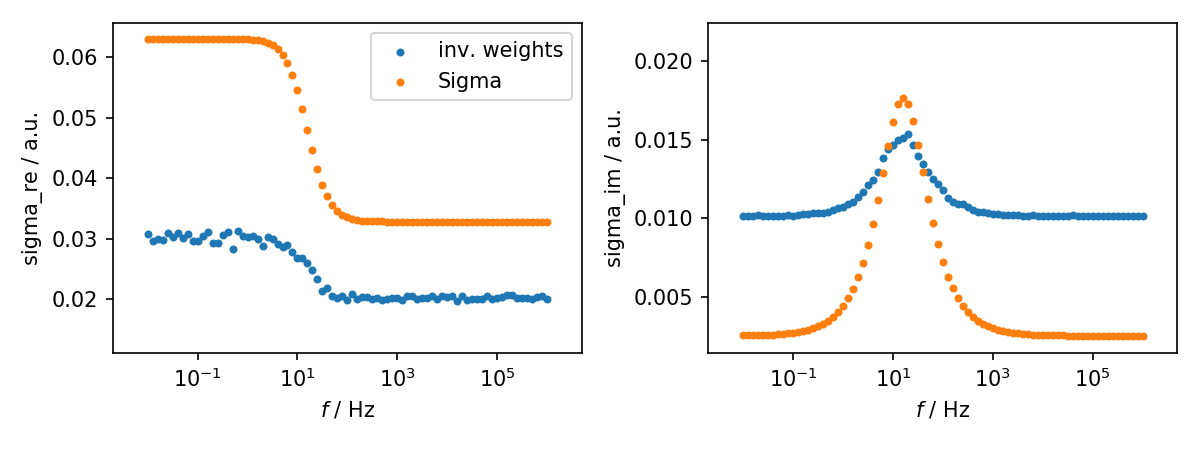

In [404]:
file = '../../../data/simulated\Z_RC_Macdonald_2.5.csv'
Zndf = pd.read_csv(file)
Z = Zndf['Zreal'].values + 1j*Zndf['Zimag'].values
freq = Zndf['Freq'].values

weights = dr._format_weights(freq,Z,'prop_adj','both')
inv_weights = 1/np.real(weights) + 1j/np.imag(weights)
# fig,axes = plt.subplots()

wdf = gt.construct_eis_df(freq,1e-2*inv_weights)
axes = gt.plot_bode(wdf,cols=['Zreal','Zimag'],label='inv. weights',unit_scale='',invert_Zimag=False)
gt.plot_bode(Zndf,cols=['sigma_re','sigma_im'],axes=axes,label='Sigma',unit_scale='')
# dr.ridge_fit(freq,Z,part='imag',hyper_lambda=False,reg_ord=2,dZ=False,scale_Z=False,nonneg=True,
#                   penalty='discrete',max_iter=50,weights='prop_adj',lambda_0=1e-10)

axes[0].legend()

# plot_drt_result(dr,Zndf,'RC',label='Ridge',trunc_tau_plot=False)

In [378]:
Zndf

,Freq,Zreal,Zimag,Zmod,Zphz,sigma_re,sigma_im
0,1000000.000000,1.000039,0.000225,1.000039,0.012883,0.001683,0.001683
1,794328.234724,0.997310,-0.003060,0.997315,-0.175792,0.001683,0.001683
2,630957.344480,0.999050,0.000976,0.999050,0.055980,0.001683,0.001683
3,501187.233627,0.998654,-0.001144,0.998655,-0.065617,0.001683,0.001683
4,398107.170553,0.999925,-0.000334,0.999925,-0.019139,0.001683,0.001683
...,...,...,...,...,...,...,...
76,0.025119,2.001953,-0.003313,2.001955,-0.094810,0.003368,0.003368
77,0.019953,1.995278,0.001925,1.995279,0.055285,0.003368,0.003368
78,0.015849,2.000538,0.001264,2.000539,0.036215,0.003367,0.003367
79,0.012589,2.001709,-0.010182,2.001735,-0.291436,0.003367,0.003367


In [53]:
# dr = drt.DRT()
file = '../../../data/simulated\Z_Gerischer_uniform_0.25.csv'
run_cv_fit(dr,file,basis_freq=None,epsilon=5,nonneg=True,weights='unity')

<IPython.core.display.Javascript object>

AttributeError: 'DRT' object has no attribute 'drt'

complex

# Simulated data

## Basic circuits

In [4]:
dr = drt.DRT()
files = glob.glob('../../../data/simulated/Z_*Orazem*.csv')
# trunc and RC-ZARC circuits need different basis tau
files = [f for f in files if f.find('trunc')==-1 and f.find('RC-ZARC')==-1 and f.find('DDT')==-1]
# assign epsilon values for circuits
circ_epsilon = {'ZARC':2,'2ZARC':2,'RC-ZARC':5,'ZARC-RL':3,'RC':5,'2RC':5,'Gerischer':5}

In [5]:
files

['../../../data/simulated\\Z_2RC_Orazem_0.25.csv',
 '../../../data/simulated\\Z_2RC_Orazem_1.0.csv',
 '../../../data/simulated\\Z_2RC_Orazem_2.5.csv',
 '../../../data/simulated\\Z_2ZARC_Orazem_0.25.csv',
 '../../../data/simulated\\Z_2ZARC_Orazem_1.0.csv',
 '../../../data/simulated\\Z_2ZARC_Orazem_2.5.csv',
 '../../../data/simulated\\Z_Gerischer_Orazem_0.25.csv',
 '../../../data/simulated\\Z_Gerischer_Orazem_1.0.csv',
 '../../../data/simulated\\Z_Gerischer_Orazem_2.5.csv',
 '../../../data/simulated\\Z_RC_Orazem_0.25.csv',
 '../../../data/simulated\\Z_RC_Orazem_1.0.csv',
 '../../../data/simulated\\Z_RC_Orazem_2.5.csv',
 '../../../data/simulated\\Z_ZARC-RL_Orazem_0.25.csv',
 '../../../data/simulated\\Z_ZARC-RL_Orazem_1.0.csv',
 '../../../data/simulated\\Z_ZARC-RL_Orazem_2.5.csv',
 '../../../data/simulated\\Z_ZARC_Orazem_0.25.csv',
 '../../../data/simulated\\Z_ZARC_Orazem_1.0.csv',
 '../../../data/simulated\\Z_ZARC_Orazem_2.5.csv']

In [406]:
# Fit all basic simulated spectra 

# tau for plotting
tau_plot = np.logspace(-7,2,200)
start = time.time()

for file in files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):-4]
    
#     if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
#         print('Already ran')
#     else:
    file_start = time.time()

    # get circuit-specific epsilon
    circ = os.path.split(file)[1].split('_')[1]
    epsilon = circ_epsilon[circ]
    dr.epsilon = epsilon
    # set nonneg=False for ZARC-RL
    if circ=='ZARC-RL':
        nonneg = False
    else:
        nonneg = True
        
    # get error model and set weighting scheme accordingly
    err_model = os.path.split(file)[1].split('_')[2]
    if err_model=='uniform':
        weights='unity'
    elif err_model=='Macdonald':
        weights='prop_adj'
    elif err_model=='Orazem':
        weights='Orazem'
    # use unity weighting for all spectra as done by Ciucci and Chen (2015)
#     weights = 'unity'

    # load Z data
    Zndf = pd.read_csv(file)
    freq = Zndf['Freq'].values
    Zc = (Zndf['Zreal'] + 1j*Zndf['Zimag']).values

    # perform Re-Im CV
    fit_kw = dict(reg_ord=2,dZ=False,scale_Z=False,nonneg=nonneg,weights=weights,
                  penalty='discrete',max_iter=50)       
    cv_lambdas = np.logspace(-15,0,61)
    dr.ridge_fit(freq,Zc,lambda_0='cv',cv_lambdas=cv_lambdas,hyper_lambda=False,**fit_kw)

    # get best lambda_0
    min_lam = dr.cv_result['lambda'].values[np.argmin(dr.cv_result['totcv'])]
    if min_lam==np.min(cv_lambdas) or min_lam==np.max(cv_lambdas):
        warnings.warn('min_lam value {} for file {} is at lambda boundary!'.format(min_lam,os.path.split(file)[1]))

    # run hyperparametric fits with best lambda_0
    f_betas = [1e-2,1e-1,1,1e1,1e2]
    for f_beta in f_betas:
        Zoutfile = os.path.join(outdir,'Zout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        Goutfile = os.path.join(outdir,'Gout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        pkl = os.path.join(outdir,'obj{}_fbeta={:.3g}.pkl'.format(suffix,f_beta))

        dr.ridge_fit(freq,Zc,part='both',lambda_0=min_lam,hl_fbeta=f_beta,**fit_kw)

        # save results
        Z_pred = dr.predict_Z(freq)
        Z_res = pd.DataFrame(np.array([freq,Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])

        g_pred = dr.predict_distribution('DRT',eval_tau=tau_plot)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)

        # pickle the drt object for access to all other attributes
        save_pickle(dr,pkl)

    print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        
        
print('================================')        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../../../data/simulated\Z_2RC_Orazem_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:1318: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)*np.exp(y)*w_n*t_m/(1+np.exp(2*(y+np.log(w_n*t_m))))


Dumped pickle to results\obj_2RC_Orazem_0.25_fbeta=0.01.pkl
Dumped pickle to results\obj_2RC_Orazem_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_2RC_Orazem_0.25_fbeta=1.pkl
Dumped pickle to results\obj_2RC_Orazem_0.25_fbeta=10.pkl
Dumped pickle to results\obj_2RC_Orazem_0.25_fbeta=100.pkl
File fit time: 27.97 seconds
-------------------------------
../../../data/simulated\Z_2RC_Orazem_1.0.csv
-------------------------------


C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:53: UserWarning: min_lam value 1e-15 for file Z_2RC_Orazem_1.0.csv is at lambda boundary!


Dumped pickle to results\obj_2RC_Orazem_1.0_fbeta=0.01.pkl
Dumped pickle to results\obj_2RC_Orazem_1.0_fbeta=0.1.pkl
Dumped pickle to results\obj_2RC_Orazem_1.0_fbeta=1.pkl
Dumped pickle to results\obj_2RC_Orazem_1.0_fbeta=10.pkl
Dumped pickle to results\obj_2RC_Orazem_1.0_fbeta=100.pkl
File fit time: 27.41 seconds
-------------------------------
../../../data/simulated\Z_2RC_Orazem_2.5.csv
-------------------------------
Dumped pickle to results\obj_2RC_Orazem_2.5_fbeta=0.01.pkl
Dumped pickle to results\obj_2RC_Orazem_2.5_fbeta=0.1.pkl
Dumped pickle to results\obj_2RC_Orazem_2.5_fbeta=1.pkl
Dumped pickle to results\obj_2RC_Orazem_2.5_fbeta=10.pkl
Dumped pickle to results\obj_2RC_Orazem_2.5_fbeta=100.pkl
File fit time: 27.54 seconds
-------------------------------
../../../data/simulated\Z_2ZARC_Orazem_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:369: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_2ZARC_Orazem_0.25_fbeta=0.01.pkl
Dumped pickle to results\obj_2ZARC_Orazem_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_2ZARC_Orazem_0.25_fbeta=1.pkl
Dumped pickle to results\obj_2ZARC_Orazem_0.25_fbeta=10.pkl
Dumped pickle to results\obj_2ZARC_Orazem_0.25_fbeta=100.pkl
File fit time: 34.88 seconds
-------------------------------
../../../data/simulated\Z_2ZARC_Orazem_1.0.csv
-------------------------------
Dumped pickle to results\obj_2ZARC_Orazem_1.0_fbeta=0.01.pkl
Dumped pickle to results\obj_2ZARC_Orazem_1.0_fbeta=0.1.pkl
Dumped pickle to results\obj_2ZARC_Orazem_1.0_fbeta=1.pkl
Dumped pickle to results\obj_2ZARC_Orazem_1.0_fbeta=10.pkl
Dumped pickle to results\obj_2ZARC_Orazem_1.0_fbeta=100.pkl
File fit time: 29.44 seconds
-------------------------------
../../../data/simulated\Z_2ZARC_Orazem_2.5.csv
-------------------------------
Dumped pickle to results\obj_2ZARC_Orazem_2.5_fbeta=0.01.pkl
Dumped pickle to results\obj_2ZARC_Orazem_2.5_fbeta=0.1.pk

## RC-ZARC circuit

In [307]:
basis_tau = np.logspace(-2,3,51)
dr_rcz = drt.DRT(basis_freq=1/(2*np.pi*basis_tau),epsilon=5)
rcz_files = glob.glob(os.path.join(datadir,'simulated/Z_RC-ZARC*.csv'))

In [407]:
# Fit RC-ZARC spectra

# tau for plotting
tau_plot = np.logspace(np.log10(np.exp(-5)),np.log10(np.exp(5.5)),200)
start = time.time()

for file in rcz_files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):-4]
    
#     if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
#         print('Already ran')
#     else:
    file_start = time.time()

    nonneg = True
        
    # get error model and set weighting scheme accordingly
    err_model = os.path.split(file)[1].split('_')[2]
    if err_model=='uniform':
        weights='unity'
    elif err_model=='Macdonald':
        weights='prop_adj'
    elif err_model=='Orazem':
        weights='Orazem'

    # load Z data
    Zndf = pd.read_csv(file)
    freq = Zndf['Freq'].values
    Zc = (Zndf['Zreal'] + 1j*Zndf['Zimag']).values

    # perform Re-Im CV
    fit_kw = dict(reg_ord=2,dZ=False,scale_Z=False,nonneg=nonneg,weights=weights,
                  penalty='discrete',max_iter=50)       
    dr_rcz.ridge_fit(freq,Zc,lambda_0='cv',cv_lambdas=np.logspace(-10,0,41),hyper_lambda=False,**fit_kw)
    
    # get best lambda_0
    min_lam = dr_rcz.cv_result['lambda'].values[np.argmin(dr_rcz.cv_result['totcv'])]
    if min_lam==np.min(lambdas) or min_lam==np.max(lambdas):
        warnings.warn('min_lam value {} for file {} is at lambda boundary!'.format(min_lam,os.path.split(file)[1]))

    # run hyperparametric fits with best lambda_0
    f_betas = [1e-2,1e-1,1,1e1,1e2]
    for f_beta in f_betas:
        Zoutfile = os.path.join(outdir,'Zout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        Goutfile = os.path.join(outdir,'Gout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        pkl = os.path.join(outdir,'obj{}_fbeta={:.3g}.pkl'.format(suffix,f_beta))

        dr_rcz.ridge_fit(freq,Zc,part='both',lambda_0=min_lam,hl_fbeta=f_beta,**fit_kw)

        # save results
        Z_pred = dr_rcz.predict_Z(freq)
        Z_res = pd.DataFrame(np.array([freq,Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])

        g_pred = dr_rcz.predict_distribution('DRT',eval_tau=tau_plot)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)

        # pickle the drt object for access to all other attributes
        save_pickle(dr_rcz,pkl)

    print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        
print('================================')        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../../../data\simulated\Z_RC-ZARC_Macdonald_0.25.csv
-------------------------------
Dumped pickle to results\obj_RC-ZARC_Macdonald_0.25_fbeta=0.01.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_0.25_fbeta=1.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_0.25_fbeta=10.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_0.25_fbeta=100.pkl
File fit time: 8.93 seconds
-------------------------------
../../../data\simulated\Z_RC-ZARC_Macdonald_1.0.csv
-------------------------------
Dumped pickle to results\obj_RC-ZARC_Macdonald_1.0_fbeta=0.01.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_1.0_fbeta=0.1.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_1.0_fbeta=1.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_1.0_fbeta=10.pkl
Dumped pickle to results\obj_RC-ZARC_Macdonald_1.0_fbeta=100.pkl
File fit time: 7.96 seconds
-------------------------------
../../../data\simulated\Z_RC

## trunc circuit

In [34]:
dr_trunc = drt.DRT(basis_freq=np.logspace(6,-2,81),epsilon=3)
trunc_files = glob.glob(os.path.join(datadir,'simulated/Z_trunc*.csv'))

In [38]:
# Fit trunc spectra

# tau for plotting
tau_plot = np.logspace(-7,2,200)
start = time.time()

for file in trunc_files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):-4]
    
#     if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
#         print('Already ran')
#     else:
    file_start = time.time()

    nonneg = False
        
    # get error model and set weighting scheme accordingly
    err_model = os.path.split(file)[1].split('_')[2]
    if err_model=='uniform':
        weights='unity'
    elif err_model=='Macdonald':
        weights='prop_adj'
    elif err_model=='Orazem':
        weights='Orazem'

    # load Z data
    Zndf = pd.read_csv(file)
    freq = Zndf['Freq'].values
    Zc = (Zndf['Zreal'] + 1j*Zndf['Zimag']).values

    # perform Re-Im CV
    fit_kw = dict(reg_ord=2,dZ=False,scale_Z=False,nonneg=nonneg,weights=weights,
                  penalty='discrete',max_iter=50)       
    lambdas = np.logspace(-10,0,41)
    dr_trunc.ridge_fit(freq,Zc,lambda_0='cv',cv_lambdas=lambdas,hyper_lambda=False,**fit_kw)
    
    # get best lambda_0
    min_lam = dr_trunc.cv_result['lambda'].values[np.argmin(dr_trunc.cv_result['totcv'])]
    if min_lam==np.min(lambdas) or min_lam==np.max(lambdas):
        warnings.warn('min_lam value {} for file {} is at lambda boundary!'.format(min_lam,os.path.split(file)[1]))

    # run hyperparametric fits with best lambda_0
    f_betas = [1e-2,1e-1,1,1e1,1e2]
    for f_beta in f_betas:
        Zoutfile = os.path.join(outdir,'Zout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        Goutfile = os.path.join(outdir,'Gout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        pkl = os.path.join(outdir,'obj{}_fbeta={:.3g}.pkl'.format(suffix,f_beta))

        dr_trunc.ridge_fit(freq,Zc,part='both',lambda_0=min_lam,hl_fbeta=f_beta,**fit_kw)

        # save results
        Z_pred = dr_trunc.predict_Z(freq)
        Z_res = pd.DataFrame(np.array([freq,Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])

        g_pred = dr_trunc.predict_distribution('DRT',eval_tau=tau_plot)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)

        # pickle the drt object for access to all other attributes
        save_pickle(dr_trunc,pkl)

    print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        
print('================================')        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../../../data\simulated\Z_trunc_Macdonald_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_Macdonald_0.25_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_Macdonald_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_trunc_Macdonald_0.25_fbeta=1.pkl
Dumped pickle to results\obj_trunc_Macdonald_0.25_fbeta=10.pkl
Dumped pickle to results\obj_trunc_Macdonald_0.25_fbeta=100.pkl
File fit time: 29.71 seconds
-------------------------------
../../../data\simulated\Z_trunc_Macdonald_1.0.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_Macdonald_1.0_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_Macdonald_1.0_fbeta=0.1.pkl
Dumped pickle to results\obj_trunc_Macdonald_1.0_fbeta=1.pkl
Dumped pickle to results\obj_trunc_Macdonald_1.0_fbeta=10.pkl
Dumped pickle to results\obj_trunc_Macdonald_1.0_fbeta=100.pkl
File fit time: 27.56 seconds
-------------------------------
../../../data\simulated\Z_trunc_noiseless.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_noiseless_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_noiseless_fbeta=0.1.pkl
Dumped pickle to results\obj_trunc_noiseless_fbeta=1.pkl
Dumped pickle to results\obj_trunc_noiseless_fbeta=10.pkl
Dumped pickle to results\obj_trunc_noiseless_fbeta=100.pkl
File fit time: 27.57 seconds
-------------------------------
../../../data\simulated\Z_trunc_noiseless_FullRange.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_noiseless_FullRange_fbeta=0.01.pkl
Dumped pickle to results\obj_trunc_noiseless_FullRange_fbeta=0.1.pkl
Dumped pickle to results\obj_trunc_noiseless_FullRange_fbeta=1.pkl
Dumped pickle to results\obj_trunc_noiseless_FullRange_fbeta=10.pkl
Dumped pickle to results\obj_trunc_noiseless_FullRange_fbeta=100.pkl
File fit time: 15.03 seconds
-------------------------------
../../../data\simulated\Z_trunc_uniform_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_uniform_0.25_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_uniform_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_trunc_uniform_0.25_fbeta=1.pkl
Dumped pickle to results\obj_trunc_uniform_0.25_fbeta=10.pkl
Dumped pickle to results\obj_trunc_uniform_0.25_fbeta=100.pkl
File fit time: 33.58 seconds
-------------------------------
../../../data\simulated\Z_trunc_uniform_1.0.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_uniform_1.0_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_trunc_uniform_1.0_fbeta=0.1.pkl
Dumped pickle to results\obj_trunc_uniform_1.0_fbeta=1.pkl
Dumped pickle to results\obj_trunc_uniform_1.0_fbeta=10.pkl
Dumped pickle to results\obj_trunc_uniform_1.0_fbeta=100.pkl
File fit time: 27.52 seconds
Total fit time: 2.68 minutes


## DDT

In [54]:
tp_files = glob.glob(os.path.join(datadir,'simulated/Z_*TP-DDT*.csv'))
bp_files = glob.glob(os.path.join(datadir,'../data/simulated/Z_*BP-DDT*.csv'))

tp_ddt = drt.DRT(distributions={'DDT':{'kernel':'DDT','symmetry':'planar','bc':'transmissive','dist_type':'parallel'}},
                epsilon=3)
bp_ddt = drt.DRT(distributions={'DDT':{'kernel':'DDT','symmetry':'planar','bc':'blocking','dist_type':'parallel',
                                      'basis_freq':np.logspace(5,-2,71)}},
                 epsilon=3
                )

In [57]:
tau_plot = np.logspace(-7,2,200)
start = time.time()

for files,dr in zip([tp_files,bp_files],[tp_ddt,bp_ddt]):
    for file in files:
        print('-------------------------------')
        print(file)
        print('-------------------------------')
        fname = os.path.split(file)[1]
        suffix = fname[fname.find('_'):-4]

    #     if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
    #         print('Already ran')
    #     else:
        file_start = time.time()

        nonneg = True
        # modulus weighting works best for fitting admittance
        weights='modulus'

        # load Z data
        Zndf = pd.read_csv(file)
        freq = Zndf['Freq'].values
        Zc = (Zndf['Zreal'] + 1j*Zndf['Zimag']).values

        # perform Re-Im CV
        fit_kw = dict(reg_ord=2,dZ=False,scale_Z=False,nonneg=nonneg,weights=weights,
                      penalty='discrete',max_iter=50)      
        if fname=='Z_BimodalBP-DDT_uniform_0.25.csv':
            # this file needs higher lambda value
            lambdas = np.logspace(-5,5,41)
        else:
            lambdas = np.logspace(-10,0,41)
        min_lam = dr.ridge_ReImCV(freq,Zc,lambdas=lambdas,**fit_kw)
        if min_lam==np.min(lambdas) or min_lam==np.max(lambdas):
            warnings.warn('min_lam value {} for file {} is at lambda boundary!'.format(min_lam,fname))

        # run hyperparametric fits with best lambda_0
        f_betas = [1e-2,1e-1,1,1e1,1e2]
        for f_beta in f_betas:
            Zoutfile = os.path.join(outdir,'Zout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
            Goutfile = os.path.join(outdir,'Gout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
            pkl = os.path.join(outdir,'obj{}_fbeta={:.3g}.pkl'.format(suffix,f_beta))

            dr.ridge_fit(freq,Zc,part='both',lambda_0=min_lam,hl_fbeta=f_beta,**fit_kw)

            # save results
            Z_pred = dr.predict_Z(freq)
            Z_res = pd.DataFrame(np.array([freq,Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])

            g_pred = dr.predict_distribution('DDT',eval_tau=tau_plot)
            g_res = pd.DataFrame(np.array([tau_plot,g_pred]).T,
                                 columns=['tau','gamma'])
            Z_res.to_csv(Zoutfile,index=False)
            g_res.to_csv(Goutfile,index=False)

            # pickle the drt object for access to all other attributes
            save_pickle(dr,pkl)

        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))

        
print('================================')        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../../../data\simulated\Z_BimodalTP-DDT_Macdonald_0.05.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.05_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.05_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.05_fbeta=1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.05_fbeta=10.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.05_fbeta=100.pkl
File fit time: 21.00 seconds
-------------------------------
../../../data\simulated\Z_BimodalTP-DDT_Macdonald_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.25_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.25_fbeta=1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.25_fbeta=10.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Macdonald_0.25_fbeta=100.pkl
File fit time: 23.23 seconds
-------------------------------
../../../data\simulated\Z_BimodalTP-DDT_noiseless.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_noiseless_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_noiseless_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_noiseless_fbeta=1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_noiseless_fbeta=10.pkl
Dumped pickle to results\obj_BimodalTP-DDT_noiseless_fbeta=100.pkl
File fit time: 17.12 seconds
-------------------------------
../../../data\simulated\Z_BimodalTP-DDT_Orazem_0.05.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.05_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.05_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.05_fbeta=1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.05_fbeta=10.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.05_fbeta=100.pkl
File fit time: 18.40 seconds
-------------------------------
../../../data\simulated\Z_BimodalTP-DDT_Orazem_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.25_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.25_fbeta=1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.25_fbeta=10.pkl
Dumped pickle to results\obj_BimodalTP-DDT_Orazem_0.25_fbeta=100.pkl
File fit time: 18.42 seconds
-------------------------------
../../../data\simulated\Z_BimodalTP-DDT_uniform_0.05.csv
-------------------------------


C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:36: UserWarning: min_lam value 1.0 for file Z_BimodalTP-DDT_uniform_0.05.csv is at lambda boundary!
../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.05_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.05_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.05_fbeta=1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.05_fbeta=10.pkl
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.05_fbeta=100.pkl
File fit time: 15.65 seconds
-------------------------------
../../../data\simulated\Z_BimodalTP-DDT_uniform_0.25.csv
-------------------------------
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.25_fbeta=0.01.pkl
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.25_fbeta=1.pkl
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.25_fbeta=10.pkl
Dumped pickle to results\obj_BimodalTP-DDT_uniform_0.25_fbeta=100.pkl
File fit time: 14.64 seconds
-------------------------------
../../../data\../data/simulated\Z_BimodalBP-DDT_Macdonald_0.05.csv
-------------------------------


../../../bayes-drt\drt.py:2040: RuntimeWarning: overflow encountered in tanh
  def Z_D(y,w_n,t_m):
../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.05_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.05_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.05_fbeta=1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.05_fbeta=10.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.05_fbeta=100.pkl
File fit time: 15.84 seconds
-------------------------------
../../../data\../data/simulated\Z_BimodalBP-DDT_Macdonald_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.25_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.25_fbeta=1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.25_fbeta=10.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Macdonald_0.25_fbeta=100.pkl
File fit time: 13.91 seconds
-------------------------------
../../../data\../data/simulated\Z_BimodalBP-DDT_noiseless.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_noiseless_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_noiseless_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_noiseless_fbeta=1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_noiseless_fbeta=10.pkl
Dumped pickle to results\obj_BimodalBP-DDT_noiseless_fbeta=100.pkl
File fit time: 12.16 seconds
-------------------------------
../../../data\../data/simulated\Z_BimodalBP-DDT_Orazem_0.05.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.05_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.05_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.05_fbeta=1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.05_fbeta=10.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.05_fbeta=100.pkl
File fit time: 12.08 seconds
-------------------------------
../../../data\../data/simulated\Z_BimodalBP-DDT_Orazem_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.25_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.25_fbeta=1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.25_fbeta=10.pkl
Dumped pickle to results\obj_BimodalBP-DDT_Orazem_0.25_fbeta=100.pkl
File fit time: 11.96 seconds
-------------------------------
../../../data\../data/simulated\Z_BimodalBP-DDT_uniform_0.05.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.05_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.05_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.05_fbeta=1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.05_fbeta=10.pkl
Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.05_fbeta=100.pkl
File fit time: 11.25 seconds
-------------------------------
../../../data\../data/simulated\Z_BimodalBP-DDT_uniform_0.25.csv
-------------------------------


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.25_fbeta=0.01.pkl


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.25_fbeta=0.1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.25_fbeta=1.pkl
Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.25_fbeta=10.pkl
Dumped pickle to results\obj_BimodalBP-DDT_uniform_0.25_fbeta=100.pkl
File fit time: 12.02 seconds
Total fit time: 3.63 minutes


# Experimental data

## LIB data

In [206]:
lib_files = ['DRTtools_LIB_data.txt','DRTtools_LIB_data_qtr.csv']
lib_files = [os.path.join(datadir,'experimental',f) for f in lib_files]
lib_suffixes = ['_LIB_data','_LIB_data_qtr']

lib_basis_freq = np.logspace(4,-5,91)
lib_tau = 1/(2*np.pi*lib_basis_freq)

dr_lib = drt.DRT(basis_freq=lib_basis_freq,epsilon=3)

In [209]:
dr = dr_lib
start = time.time()
tau_plot_lib = np.logspace(-5,4,200)
for file,suffix in zip(lib_files,lib_suffixes):
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    fname = os.path.split(file)[1]

#     if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
#         print('Already ran')
#     else:
    file_start = time.time()

    nonneg = True
    weights='unity'

    # load Z data
    if file[-3:]=='txt':
        Zndf = pd.read_csv(file,sep='\t',header=None)
        Zndf = pd.DataFrame(Zndf.values,columns=['Freq','Zreal','Zimag'])
    else:
        Zndf = pd.read_csv(file)
    freq = Zndf['Freq'].values
    Zc = (Zndf['Zreal'] + 1j*Zndf['Zimag']).values

    # perform Re-Im CV
    fit_kw = dict(reg_ord=2,dZ=False,scale_Z=False,nonneg=nonneg,weights=weights,
                  penalty='discrete',max_iter=50)      
    lambdas = np.logspace(-12,-2,41)
    min_lam = dr.ridge_ReImCV(freq,Zc,lambdas=lambdas,**fit_kw)
    if min_lam==np.min(lambdas) or min_lam==np.max(lambdas):
        warnings.warn('min_lam value {} for file {} is at lambda boundary!'.format(min_lam,fname))

    # run hyperparametric fits with best lambda_0
    f_betas = [1e-2,1e-1,1,1e1,1e2]
    for f_beta in f_betas:
        print(suffix)
        Zoutfile = os.path.join(outdir,'Zout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        Goutfile = os.path.join(outdir,'Gout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
        pkl = os.path.join(outdir,'obj{}_fbeta={:.3g}.pkl'.format(suffix,f_beta))

        dr.ridge_fit(freq,Zc,part='both',lambda_0=min_lam,hl_fbeta=f_beta,**fit_kw)

        # save results
        Z_pred = dr.predict_Z(freq)
        Z_res = pd.DataFrame(np.array([freq,Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])

        g_pred = dr.predict_distribution('DRT',eval_tau=tau_plot_lib)
        g_res = pd.DataFrame(np.array([tau_plot_lib,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)

        # pickle the drt object for access to all other attributes
        save_pickle(dr,pkl)

    print('File fit time: {:.2f} seconds'.format(time.time()-file_start))

        
print('================================')        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../../../data\experimental\DRTtools_LIB_data.txt
-------------------------------
_LIB_data


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_LIB_data_fbeta=0.01.pkl
_LIB_data


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_LIB_data_fbeta=0.1.pkl
_LIB_data
Dumped pickle to results\obj_LIB_data_fbeta=1.pkl
_LIB_data
Dumped pickle to results\obj_LIB_data_fbeta=10.pkl
_LIB_data
Dumped pickle to results\obj_LIB_data_fbeta=100.pkl
File fit time: 26.77 seconds
-------------------------------
../../../data\experimental\DRTtools_LIB_data_qtr.csv
-------------------------------
_LIB_data_qtr


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_LIB_data_qtr_fbeta=0.01.pkl
_LIB_data_qtr


../../../bayes-drt\drt.py:448: UserWarning: Hyperparametric solution did not converge within 50 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Dumped pickle to results\obj_LIB_data_qtr_fbeta=0.1.pkl
_LIB_data_qtr
Dumped pickle to results\obj_LIB_data_qtr_fbeta=1.pkl
_LIB_data_qtr
Dumped pickle to results\obj_LIB_data_qtr_fbeta=10.pkl
_LIB_data_qtr
Dumped pickle to results\obj_LIB_data_qtr_fbeta=100.pkl
File fit time: 36.96 seconds
Total fit time: 1.06 minutes


In [211]:
dr.R_inf

0.10913792982407555

## Protonic ceramic microelectrode

In [173]:
tco_file = os.path.join(datadir,'experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt')
suffix = '_PDAC'
tco_df = gt.read_eis_zdata(tco_file)
Zc = tco_df['Zreal'].values + 1j*tco_df['Zimag'].values
freq = tco_df['Freq'].values

dr_tco = drt.DRT(basis_freq=np.logspace(7,-3,101),epsilon=3)
# tau for plotting
tau_plot_tco = np.logspace(-7,4,200)

# perform Re-Im CV
# use scale_Z=True to get Z to regular scale - makes hyper-w tuning easier
fit_kw = dict(reg_ord=2,dZ=False,scale_Z=False,nonneg=True,weights='unity',
              penalty='discrete',max_iter=50)      
lambdas = np.logspace(-10,0,41)
min_lam = dr_tco.ridge_ReImCV(freq,Zc,lambdas=lambdas,**fit_kw)
if min_lam==np.min(lambdas) or min_lam==np.max(lambdas):
    warnings.warn('min_lam value {} for file {} is at lambda boundary!'.format(min_lam,fname))

dr = dr_tco
for hyper_w in [True]:#,False]:
    if hyper_w:
        # hyper-weights fit
        Zoutfile = os.path.join(outdir,'Zout{}_hyper-w.csv'.format(suffix,f_beta))
        Goutfile = os.path.join(outdir,'Gout{}_hyper-w.csv'.format(suffix,f_beta))
        pkl = os.path.join(outdir,'obj{}_hyper-w.pkl'.format(suffix,f_beta))

        dr.ridge_fit(freq,Zc,hyper_weights=True,hyper_lambda=False,hw_wbar='unity',hw_beta=1e10,
                     lambda_0=min_lam,**fit_kw)

        # save results
        Z_pred = dr.predict_Z(freq)
        Z_res = pd.DataFrame(np.array([freq,Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])
        Z_res['sigma_re'] = 1/dr.distribution_fits['DRT']['weights'].real**0.5
        Z_res['sigma_im'] = 1/dr.distribution_fits['DRT']['weights'].imag**0.5

        g_pred = dr.predict_distribution('DRT',eval_tau=tau_plot_tco)
        g_res = pd.DataFrame(np.array([tau_plot_tco,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)

        # pickle the drt object for access to all other attributes
        save_pickle(dr,pkl)
    else:
        # hyper-lambda fit
        f_betas = [1e-2,1e-1,1,1e1,1e2]
        for f_beta in f_betas:
            Zoutfile = os.path.join(outdir,'Zout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
            Goutfile = os.path.join(outdir,'Gout{}_fbeta={:.3g}.csv'.format(suffix,f_beta))
            pkl = os.path.join(outdir,'obj{}_fbeta={:.3g}.pkl'.format(suffix,f_beta))

            dr.ridge_fit(freq,Zc,part='both',lambda_0=min_lam,hl_fbeta=f_beta,**fit_kw)

            # save results
            Z_pred = dr.predict_Z(freq)
            Z_res = pd.DataFrame(np.array([freq,Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])

            g_pred = dr.predict_distribution('DRT',eval_tau=tau_plot_tco)
            g_res = pd.DataFrame(np.array([tau_plot_tco,g_pred]).T,
                                 columns=['tau','gamma'])
            Z_res.to_csv(Zoutfile,index=False)
            g_res.to_csv(Goutfile,index=False)

            # pickle the drt object for access to all other attributes
            save_pickle(dr,pkl)


Dumped pickle to results\obj_PDAC_hyper-w.pkl


In [105]:
min_lam

5.623413251903491e-06

9506303.694392884


<IPython.core.display.Javascript object>


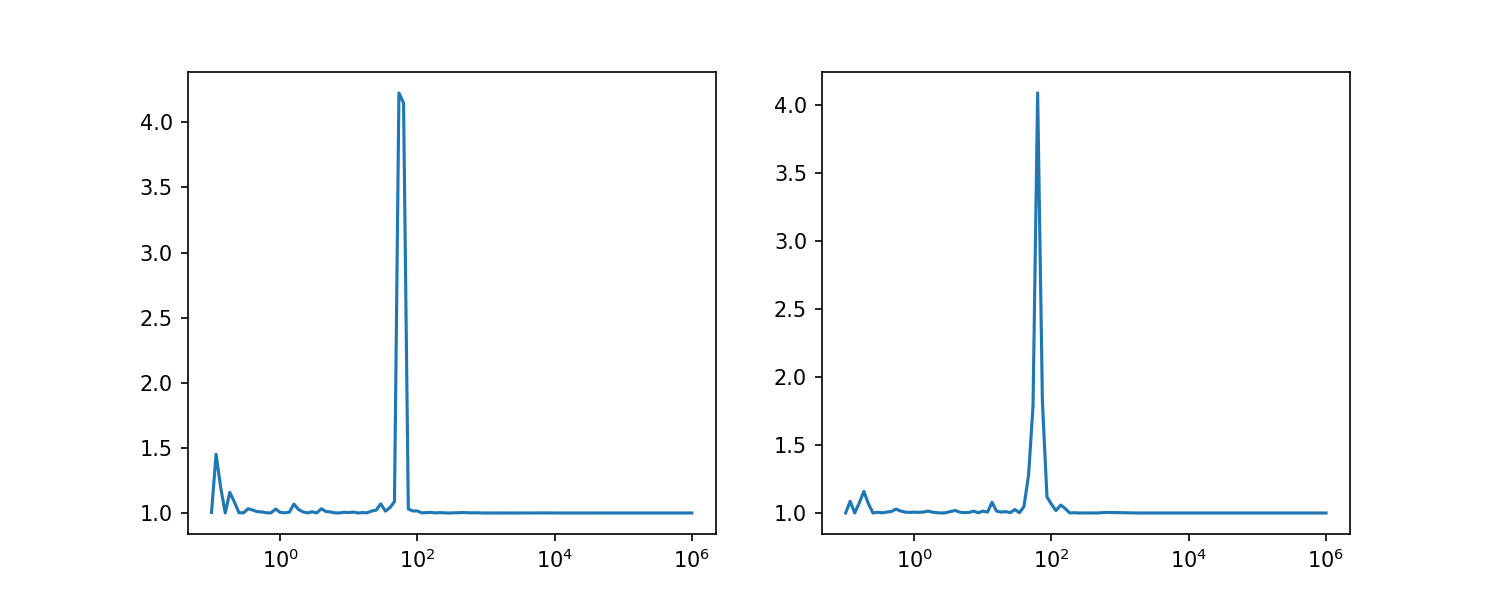

In [170]:
dr.ridge_fit(freq,Zc,hyper_weights=True,hyper_lambda=False,hw_beta=1e10,hw_wbar='unity',
             lambda_0=min_lam,
             reg_ord=2,dZ=False,scale_Z=False,nonneg=True,weights='unity',
              penalty='discrete',max_iter=50)#**fit_kw)
print(np.max(dr.predict_Z(freq).real))
dr.distribution_fits['DRT']['weights']
fig,axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(freq,1/dr.distribution_fits['DRT']['weights'].real**0.5)
axes[1].plot(freq,1/dr.distribution_fits['DRT']['weights'].imag**0.5)

for ax in axes:
    ax.set_xscale('log')

<IPython.core.display.Javascript object>


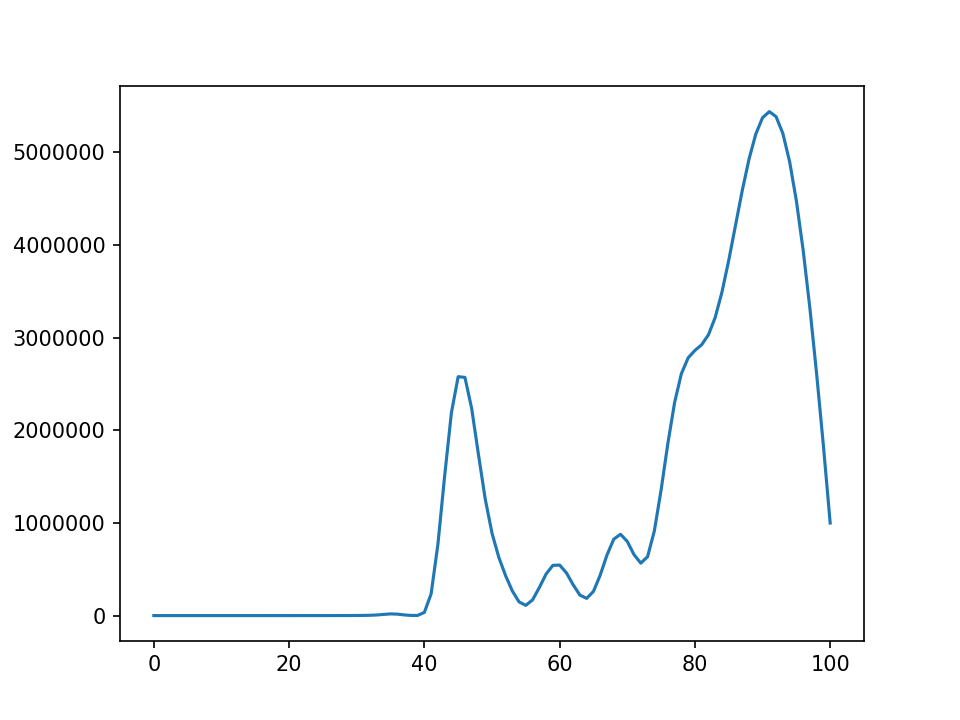

In [171]:
fig,ax = plt.subplots()
ax.plot(dr.predict_distribution('DRT'))

In [186]:
drr.coef_@drr.M2@drr.coef_, \
drr.coef_@(drr.L2@drr.L2.T)@drr.coef_, \
np.sum((drr.L2@drr.coef_)**2)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 81 is different from 83)

1.001 1.0


../../../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


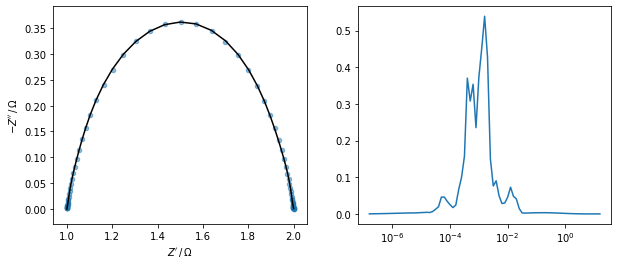

In [91]:
beta_cv = bb.ravel()[np.argmin(totcv)]
lam_cv = ll.ravel()[np.argmin(totcv)]
print(beta_cv,lam_cv)
# lam_cv=1e-5

drr.ridge_fit(freq,Zc,beta=beta_cv,lambda_0=lam_cv,hyper_penalty='cholesky',reg_ord=2,dZ=False,scale_Z=True)
Z_pred = drr.predict(freq)
df_pred = gt.construct_eis_df(freq,Z_pred)

fig,axes = plt.subplots(1,2,figsize=(10,4))

gt.plot_nyquist(Zndf,ax=axes[0],s=20,alpha=0.5)
gt.plot_nyquist(df_pred,ax=axes[0],plot_func='plot',c='k')

axes[1].plot(drr.tau,drr.drt())
axes[1].set_xscale('log')

In [77]:
Zicv

array([[4.29887854e-04, 3.72455109e-04, 3.73086226e-04, 3.73157198e-04,
        3.73164312e-04, 3.73165024e-04, 3.73165095e-04],
       [1.47313879e-04, 1.10259522e-03, 7.49790768e-04, 7.52082753e-04,
        7.52322727e-04, 7.52346745e-04, 7.52349147e-04],
       [1.85998297e-04, 3.21899887e-04, 3.89762400e-03, 3.93560239e-03,
        3.94017064e-03, 3.94063345e-03, 3.94067975e-03],
       [9.05909842e-05, 6.27054670e-04, 1.00381172e-02, 1.87634950e-02,
        1.88038411e-02, 1.88080374e-02, 1.88084573e-02],
       [6.18866390e-05, 2.27157904e-04, 1.11149316e-03, 7.14412885e-02,
        7.15149386e-02, 7.15247514e-02, 7.15257501e-02],
       [1.05293160e-04, 2.26777230e-04, 5.27673092e-04, 1.91835995e-01,
        1.91055133e-01, 1.90981413e-01, 1.90974056e-01],
       [1.10277446e-04, 3.20094014e-04, 7.25246391e-04, 1.20582105e-03,
        4.06748651e-01, 4.06308933e-01, 4.06264579e-01]])

In [25]:
"maybe: optimize lambda first for regular ridge, then optimize beta with fixed lambda for hyper-ridge?"
lambdas = np.logspace(-5,1,7)

Zrcv = np.zeros_like(lambdas)
Zicv = np.zeros_like(lambdas)

start = time.time()
for i,lam in enumerate(lambdas):
    # fit
    drr.ridge_fit(freq,Zc,part='real',lambda_0=lam,hyper_lambda=False,reg_ord=2,dZ=False,scale_Z=True,nonneg=True)
    dri.ridge_fit(freq,Zc,part='imag',lambda_0=lam,hyper_lambda=False,reg_ord=2,dZ=False,scale_Z=True,nonneg=True)
    
    Zi_pred = np.imag(drr.predict(freq))
    Zr_pred = np.real(dri.predict(freq))
    
    Zr_err = np.sum((Zc.real - Zr_pred)**2)
    Zi_err = np.sum((Zc.imag - Zi_pred)**2)
    
    Zrcv[i] = Zr_err
    Zicv[i] = Zi_err

elapsed = time.time() - start
print('Run time:',elapsed)

totcv = Zicv + Zrcv

Run time: 0.14760541915893555


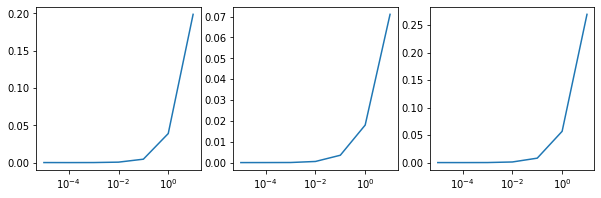

In [26]:
fig,axes = plt.subplots(1,3,figsize=(10,3))

for ax, cv in zip(axes,[Zrcv,Zicv,totcv]):
    ax.plot(lambdas,cv)
    ax.set_xscale('log')

In [28]:
lambdas[np.argmin(totcv)], totcv

(0.0001,
 array([1.01860617e-04, 8.36714744e-05, 1.63895653e-04, 1.19704311e-03,
        8.13994483e-03, 5.69275474e-02, 2.69618268e-01]))

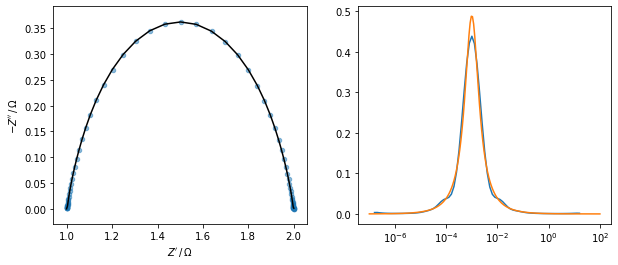

In [37]:
lam = lambdas[np.argmin(totcv)]
# lam_cv=1e-5

drr.ridge_fit(freq,Zc,lambda_0=lam,hyper_lambda=False,reg_ord=2,dZ=False,scale_Z=True,nonneg=True)
Z_pred = drr.predict(freq)
df_pred = gt.construct_eis_df(freq,Z_pred)

fig,axes = plt.subplots(1,2,figsize=(10,4))

gt.plot_nyquist(Zndf,ax=axes[0],s=20,alpha=0.5)
gt.plot_nyquist(df_pred,ax=axes[0],plot_func='plot',c='k')

axes[1].plot(drr.tau,drr.drt())
axes[1].plot(g_true['tau'],g_true['gamma'])
axes[1].set_xscale('log')

In [38]:
drr.coef_

array([9.97286135e-01, 3.77552193e-10, 2.59279866e-03, 2.00995226e-03,
       1.54296479e-03, 1.19387475e-03, 9.69650738e-04, 8.26532756e-04,
       7.38717544e-04, 6.89125655e-04, 6.66645182e-04, 6.64493054e-04,
       6.79155919e-04, 7.09859224e-04, 7.58539650e-04, 8.30311202e-04,
       9.34491803e-04, 1.08635540e-03, 1.30982626e-03, 1.64104276e-03,
       2.13016692e-03, 2.82697621e-03, 3.72035152e-03, 4.68695477e-03,
       5.73264149e-03, 7.30520319e-03, 9.90255374e-03, 1.35483108e-02,
       1.75019011e-02, 2.02670785e-02, 2.14899119e-02, 2.24245189e-02,
       2.58841524e-02, 3.56728593e-02, 5.53096867e-02, 8.63924133e-02,
       1.27152555e-01, 1.72195135e-01, 2.13485090e-01, 2.42488655e-01,
       2.52720293e-01, 2.41801221e-01, 2.12237732e-01, 1.70610866e-01,
       1.25497957e-01, 8.49211390e-02, 5.42151626e-02, 3.50540283e-02,
       2.57314465e-02, 2.26074326e-02, 2.17929120e-02, 2.04579902e-02,
       1.74308758e-02, 1.32686955e-02, 9.38822055e-03, 6.72422779e-03,
      

In [47]:
betas = 1 + np.logspace(-5,1,7)

Zrcv2 = np.zeros_like(betas)
Zicv2 = np.zeros_like(betas)

start = time.time()
for i,beta in enumerate(betas):
    drr.ridge_fit(freq,Zc,part='real',beta=beta,lambda_0=lam,hyper_penalty='cholesky',reg_ord=2,dZ=False,scale_Z=True,nonneg=True)
    dri.ridge_fit(freq,Zc,part='imag',beta=beta,lambda_0=lam,hyper_penalty='cholesky',reg_ord=2,dZ=False,scale_Z=True,nonneg=True)
    
    Zi_pred = np.imag(drr.predict(freq))
    Zr_pred = np.real(dri.predict(freq))
    
    Zr_err = np.sum((Zc.real - Zr_pred)**2)
    Zi_err = np.sum((Zc.imag - Zi_pred)**2)
    
    Zrcv2[i] = Zr_err
    Zicv2[i] = Zi_err
    
elapsed = time.time() - start
print('Run time:',elapsed)

totcv2 = Zicv2 + Zrcv2

../../../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Run time: 0.49567389488220215


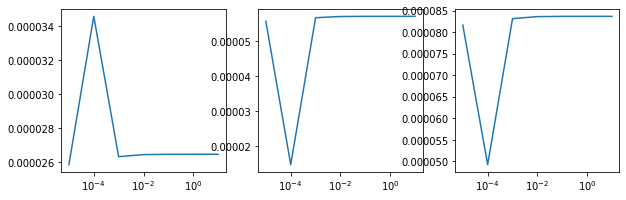

In [48]:
fig,axes = plt.subplots(1,3,figsize=(10,3))

for ax, cv in zip(axes,[Zrcv2,Zicv2,totcv2]):
    ax.plot(betas-1,cv)
    ax.set_xscale('log')

In [49]:
totcv2

array([8.16576447e-05, 4.92801260e-05, 8.31342516e-05, 8.36035172e-05,
       8.36646580e-05, 8.36707925e-05, 8.36714062e-05])

In [35]:
Zrcv2

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.64633247e-05])

../../../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


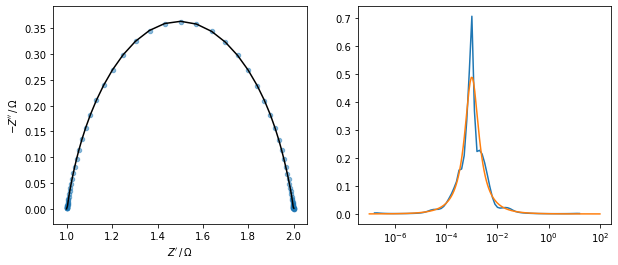

In [50]:
lam = lambdas[np.argmin(totcv)]
beta = 1+1e-4

drr.ridge_fit(freq,Zc,beta=beta,lambda_0=lam,hyper_penalty='cholesky',reg_ord=2,dZ=False,scale_Z=True,nonneg=True)
Z_pred = drr.predict(freq)
df_pred = gt.construct_eis_df(freq,Z_pred)

fig,axes = plt.subplots(1,2,figsize=(10,4))

gt.plot_nyquist(Zndf,ax=axes[0],s=20,alpha=0.5)
gt.plot_nyquist(df_pred,ax=axes[0],plot_func='plot',c='k')

axes[1].plot(drr.tau,drr.drt())
axes[1].plot(g_true['tau'],g_true['gamma'])
axes[1].set_xscale('log')

In [40]:
drr.coef_

array([9.97292553e-01, 3.76671678e-10, 2.58816917e-03, 2.00638176e-03,
       1.54025486e-03, 1.19179657e-03, 9.67978249e-04, 8.25117445e-04,
       7.37456331e-04, 6.87945069e-04, 6.65490134e-04, 6.63318638e-04,
       6.77921796e-04, 7.08526529e-04, 7.57071387e-04, 8.28679783e-04,
       9.32703851e-04, 1.08452043e-03, 1.30834021e-03, 1.64108307e-03,
       2.13494820e-03, 2.84381633e-03, 3.75899272e-03, 4.74267913e-03,
       5.76578644e-03, 7.26190087e-03, 9.76289301e-03, 1.33643515e-02,
       1.73682454e-02, 2.03016391e-02, 2.17549102e-02, 2.28747543e-02,
       2.63277484e-02, 3.57994705e-02, 5.47377607e-02, 8.49796710e-02,
       1.25952968e-01, 1.73116285e-01, 2.15904661e-01, 2.43668669e-01,
       2.51890928e-01, 2.40039822e-01, 2.11078608e-01, 1.70937260e-01,
       1.26488045e-01, 8.54869274e-02, 5.42494690e-02, 3.48749608e-02,
       2.55392691e-02, 2.24732944e-02, 2.17326764e-02, 2.04606659e-02,
       1.74744707e-02, 1.33207072e-02, 9.41922405e-03, 6.72763605e-03,
      

In [41]:
drr.lambda_vectors_

[array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001]),
 array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001

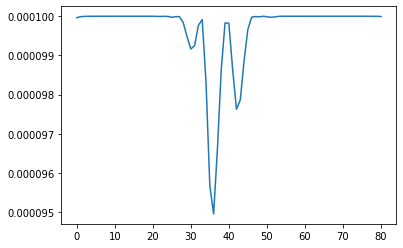

In [43]:
plt.plot(drr.lambda_vectors_[2][2:])

In [86]:
"maybe: optimize lambda first for regular ridge, then optimize beta with fixed lambda for hyper-ridge?"
lambdas = np.logspace(-3,3,7)
betas = 1 + np.logspace(-3,3,7)

bb,ll = np.meshgrid(betas,lambdas)

Zrcv = np.zeros_like(bb)
Zicv = np.zeros_like(bb)

start = time.time()
for (i,j),lam in np.ndenumerate(ll):
    # fit
    beta = bb[i,j]
#     print(beta,lam)
    drr.ridge_fit(freq,Zc,part='real',beta=beta,lambda_0=lam,hyper_penalty='cholesky',reg_ord=2,dZ=False,scale_Z=True)
    dri.ridge_fit(freq,Zc,part='imag',beta=beta,lambda_0=lam,hyper_penalty='cholesky',reg_ord=2,dZ=False,scale_Z=True)
    
    Zi_pred = np.imag(drr.predict(freq))
    Zr_pred = np.real(dri.predict(freq))
    
    Zr_err = np.sum((Zc.real - Zr_pred)**2)
    Zi_err = np.sum((Zc.imag - Zi_pred)**2)
    
    Zrcv[i,j] = Zr_err
    Zicv[i,j] = Zi_err

elapsed = time.time() - start
print('Run time:',elapsed)

totcv = Zicv + Zrcv

1.001 0.001


../../../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


1.01 0.001
1.1 0.001
2.0 0.001
11.0 0.001
101.0 0.001
1001.0 0.001
1.001 0.01
1.01 0.01
1.1 0.01
2.0 0.01
11.0 0.01
101.0 0.01
1001.0 0.01
1.001 0.1
1.01 0.1
1.1 0.1
2.0 0.1
11.0 0.1
101.0 0.1
1001.0 0.1
1.001 1.0
1.01 1.0
1.1 1.0
2.0 1.0
11.0 1.0
101.0 1.0
1001.0 1.0
1.001 10.0
1.01 10.0
1.1 10.0
2.0 10.0
11.0 10.0
101.0 10.0
1001.0 10.0
1.001 100.0
1.01 100.0
1.1 100.0
2.0 100.0
11.0 100.0
101.0 100.0
1001.0 100.0
1.001 1000.0
1.01 1000.0
1.1 1000.0
2.0 1000.0
11.0 1000.0
101.0 1000.0
1001.0 1000.0
Run time: 9.50309705734253


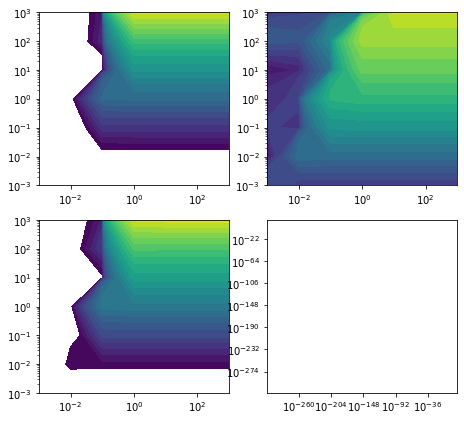

In [87]:
fig,axes = plt.subplots(2,2,figsize=(7.5,7))

axes[0,0].contourf(bb-1,ll,Zrcv,locator=ticker.LogLocator(),levels=np.logspace(-3.,1,25))
axes[0,1].contourf(bb-1,ll,Zicv,locator=ticker.LogLocator(),levels=np.logspace(-5.,0,25))
axes[1,0].contourf(bb-1,ll,totcv,locator=ticker.LogLocator(),levels=np.logspace(-3.,1,25))

for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_yscale('log')